In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
from matplotlib.pyplot import figure
from matplotlib.animation import FFMpegWriter

In [2]:
#tamanho (linear) da malha (a priori)
N = 18

In [3]:
def cria_malhas(N,tipo):
    malha = np.zeros((N,N))
    if tipo == 1:
        #malha trivial com todos os spins positivos
        for i in range(N):
            for j in range(N):
                malha[i][j] = 1
    elif tipo == 2:
        #malha trivial com todos os spins negativos
        for i in range(N):
            for j in range(N):
                malha[i][j] = -1
    elif tipo == 3:
        #malha 25% dos spins positivos (e 75% dos spins negativos)
        init_random = np.random.random((N,N))
        malha[init_random <= 0.25] = 1
        malha[init_random >= 0.25] = -1
    elif tipo == 4:
        #malha 75% dos spins positivos (e 25% dos spins negativos)
        init_random = np.random.random((N,N))
        malha[init_random <= 0.75] = 1
        malha[init_random >= 0.75] = -1
    elif tipo == 5:
        #malha completamente randomica
        init_random = np.random.random((N,N))
        prob = np.random.random()
        malha[init_random <= prob] = 1
        malha[init_random >= prob] = -1
    return malha

In [4]:
#aqui foi desconsiderado as condições de contorno (i.e., fazer o toro)
def get_energy(malha):
    # soma entre os vizinhos próximos
    kern = generate_binary_structure(2,1)
    kern[1][1] = False
    arr = - malha * convolve(malha, kern, mode='constant') #convolução
    return arr.sum()

In [5]:
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        #pega um ponto aleatório na malha e troca o spin
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] #spin inicial
        spin_f = spin_i*-1 #possível spin final
        
        #mudança na energia
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        
        #muda o estado de acordo com as probabilidades do modelo de Ising 
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
            
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
            
    return net_spins, net_energy

/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [6]:
@numba.njit("f8[:,:](f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolisArr(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
    return spin_arr

/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [7]:
def mostrarResultados(malha, malhaL, spins, energies, beta):
    bfig, axes = plt.subplots(2, 2, figsize=(30,10))
    axes[1][0].imshow(malha)
    axes[1][1].imshow(malhaL)
    ax = axes[0][0]
    ax.plot(spins)
    ax.set_xlabel('Passos de Monte Carlo')
    ax.set_ylabel('Magnetização Média')
    ax.grid()
    ax = axes[0][1]
    ax.plot(energies)
    ax.set_xlabel('Passos de Monte Carlo')
    ax.set_ylabel(r'Energia $E/J$')
    ax.grid()
    bfig.tight_layout()
    bfig.suptitle(f"Magnetização Média e Energia para beta * J = {beta}",  y=1.07, size=50)
    #bfig.suptitle("Antes ---------------------------------------------------- Depois",  y=0, size=50)
    plt.show()

In [8]:
def main(N, tipo, BJ, passosMC):
    malha = cria_malhas(N, tipo)
    get_energy(malha)
    spins, energies = metropolis(malha, passosMC, BJ, get_energy(malha))
    return malha, spins, energies

<font size="5"> Exemplo do uso do algoritmo de metropolis: </font>

In [9]:
malhaExpl = cria_malhas(N,5)  
betaJ = 0.5
passosMC = 1e6

spinsExpl, energiesExpl = metropolis(malhaExpl, passosMC, betaJ, get_energy(malhaExpl))
malhaApos = metropolisArr(malhaExpl, passosMC, betaJ, get_energy(malhaExpl))

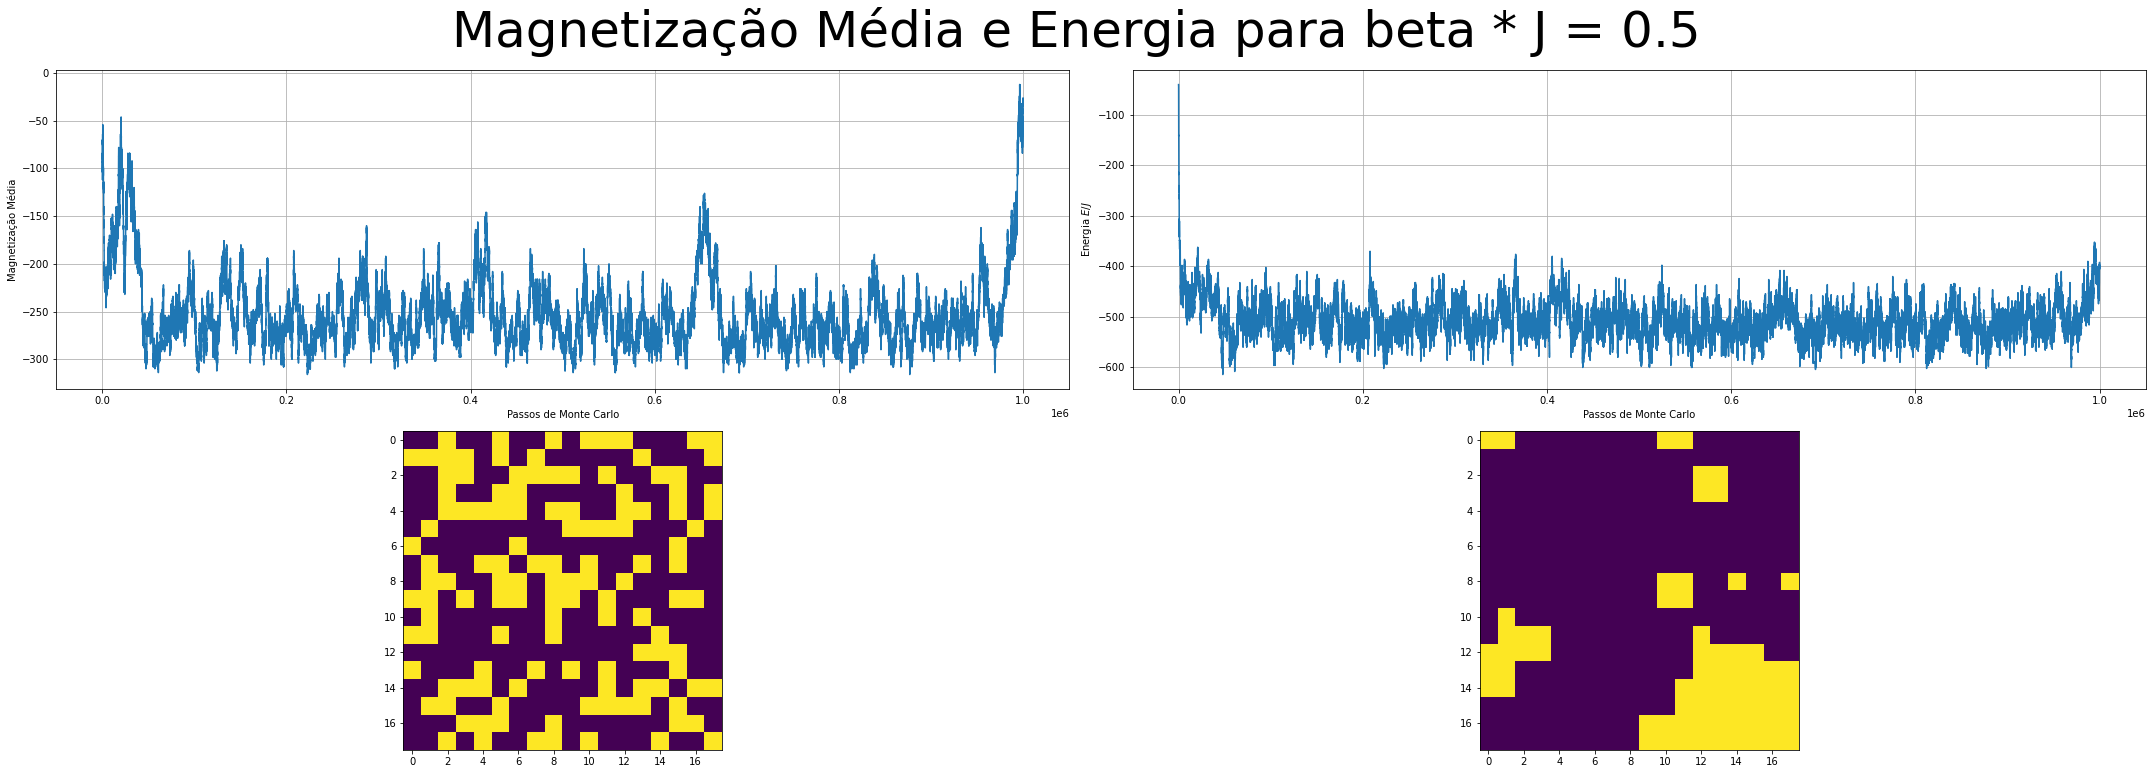

In [10]:
mostrarResultados(malhaExpl, malhaApos, spinsExpl, energiesExpl, betaJ)

<font size="5"> Façamos a simulação para uma malha de tamanho linear = $18$: </font>

In [11]:
n = 10 #tamanho da caixa
passosMC = 1.1e5 #quantidade de passos MC
Ts = np.arange(2, 3.1, 0.1) #array de T's
BJs = [] #array de BJ's (BJ = 1/T)
for e in reversed(range(len(Ts))): #comeca da temperatura mais alta
    BJs.append(1 / (Ts[e]))

In [12]:
tipo = 5 #tipo para criação de malhas: aleatório
N = 18 #tamanho da rede

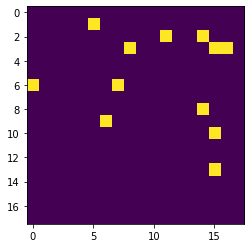

In [13]:
malha = cria_malhas(N,5) #primeira malha aleatória
plt.imshow(malha)

<font size="5"> Matrizes para as magnetizações, energias, calores específicos e susceptibilidade magnética tal que cada linha corresponda a uma temperatura BJ fixa e as colunas, então, representam o valor médio na caixa correspondente. </font>


In [14]:
ms = np.zeros((len(BJs),n))
Es = np.zeros((len(BJs),n))
Cvs = np.zeros((len(BJs),n))
chis = np.zeros((len(BJs),n))

In [15]:
for i, bj in enumerate(BJs):  # i ira indexar as linhas a uma temperatura fixa bj

#Ao modificar a temperatura, utilize como configuração inicial da nova temperatura a última
#configuração gerada na temperatura anterior, ou seja, as configurações serão alteradas apenas
#pelo processo de Monte Carlo
    
    if i == 0:
        spins, energies = metropolis(malha, passosMC, bj, get_energy(malha))
        malha_lin = metropolisArr(malha, passosMC, bj, get_energy(malha))
    else:
        spins, energies = metropolis(malha_lin, passosMC, bj, get_energy(malha_lin))
        malha_lin = metropolisArr(malha_lin, passosMC, bj, get_energy(malha_lin))
    
    #print(i,bj)
    
    for caixas in reversed(range(n)): 
        #estamos a uma temperatura BJ fixa (=> a  uma linha i fixa)
        #percorremos as colunas,i.e., as caixas
        if caixas > 0:
            ms[i][caixas] = spins[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].mean()
        # divide os últimos 1e5 pontos, suposto atingido a termalização, em caixas de tamanho
        # 1e4, e cada termo ms[i][caixas] eh a media dos spins nessa caixa a temperatura i
            Es[i][caixas] = energies[- int(1e4) * (caixas + 1) : - int(1e4) * caixas ].mean()
            Cvs[i][caixas] = BJs[i] * BJs[i] * energies[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].std()
            chis[i][caixas] = BJs[i] * spins[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].std()
        elif caixas == 0:
            ms[i][caixas] = spins[- int(1e4) : ].mean()
            Es[i][caixas] = energies[- int(1e4) : ].mean()
            Cvs[i][caixas] = BJs[i] * BJs[i] * energies[- int(1e4) : ].std()
            chis[i][caixas] = BJs[i] * spins[- int(1e4) : ].std()

In [16]:
print(f"{ms}\n{Es}\n{Cvs}\n{chis}")

[[  43.9954   -5.9574  -19.0956   -6.6722   29.5722  -78.2292   13.2036
   -34.5038  -80.45     -9.5552]
 [  -9.7972    1.3916   -4.9898   -3.3364   32.6954  -20.6232   48.8202
     4.299   -20.7802  -14.4386]
 [  67.9134   44.2458  -30.165  -102.5608  -68.2392  -52.0428   10.2082
    75.7428    6.7886    5.1968]
 [  49.3442   49.7304   39.4166   13.6852   84.673    12.727   -18.4704
   -17.8214  -64.7278   26.249 ]
 [ -85.978   -84.2564  -84.2722  -71.78     12.5506  -32.4476   -8.7048
    21.2184   -6.1106  -80.9312]
 [ -59.2928 -113.1506 -111.4098  -44.2876  -11.909    15.8868 -125.6286
   -87.5348 -136.64   -174.3988]
 [  24.0908   48.2402  160.1068   78.088   101.7362   20.5214  -41.5228
   -64.1318 -195.279  -197.2716]
 [ 145.2676  101.5128  151.91    152.7538  135.579   229.5704  170.9136
   102.3002  122.425   184.5038]
 [ 172.427   116.2348  185.42    161.5404  180.0942  105.614    95.9758
   161.426   210.0842  147.998 ]
 [ 220.3758  176.8112  174.6342  245.0238  252.2396  25

<font size="5"> Agora, façamos as médias das quantidades pelas caixas em uma temperatura $\beta$ J fixa: </font>

In [17]:
mBarra = np.zeros((len(BJs)))
EBarra = np.zeros((len(BJs)))
CvBarra = np.zeros((len(BJs)))
chiBarra = np.zeros((len(BJs)))

In [18]:
for BJ in range(len(BJs)):
    mBarra[BJ] = ms[BJ].mean() #temos a media da magnetização nas caixas para cada temperatura BJ
    EBarra[BJ] = Es[BJ].mean()
    CvBarra[BJ] = Cvs[BJ].mean()
    chiBarra[BJ] = chis[BJ].mean()

In [19]:
print(f"{mBarra}\n{EBarra}\n{CvBarra}\n{chiBarra}")

[-14.76922   1.32408  -4.29122  17.48058 -42.07118 -84.83652  -6.54218
 149.67362 153.68144 213.79774 170.19018]
[-768.3969  -474.81482 -534.61738 -579.90702 -611.5358  -653.01304
 -683.92152 -788.79864 -767.17028 -814.96834 -878.49262]
[3.419837   3.76813863 4.35353954 4.25109072 4.52823369 5.11985251
 5.96281838 6.79362212 5.26382598 7.44204029 6.49886594]
[14.17653834 11.90328979 14.72435403 16.46418474 12.64648109 17.03434393
 16.14148296 17.84649503 14.77959403 14.87406212 17.46903114]


<font size="5"> Calculamos o erro estatístico de cada quantidade nas n caixas para cada temperatura $\beta J$ fixa: </font>

In [20]:
mErr = np.zeros((len(BJs)))
EErr = np.zeros((len(BJs)))
CvErr = np.zeros((len(BJs)))
chiErr = np.zeros((len(BJs)))

<font size="5">$$\left( \Delta \overline{C_v} \right)^2 = \frac{\sum_{i=0}^{n-1} \left( \langle C_v \rangle  - C_v[i] \right)}{N \cdot (N-1)}$$ </font>


In [21]:
for BJ in range(len(BJs)):
    mSoma = 0
    ESoma = 0
    CvSoma = 0
    chiSoma = 0
    for i in range(n):
        mSoma += ( mBarra[BJ] - ms[BJ][i] )**2
        ESoma += ( EBarra[BJ] - Es[BJ][i] )**2
        CvSoma += ( CvBarra[BJ] - Cvs[BJ][i] )**2
        chiSoma += ( chiBarra[BJ] - chis[BJ][i] )**2
    mErr[BJ] = np.sqrt( mSoma / (n * (n - 1)) )
    EErr[BJ] = np.sqrt( ESoma / (n * (n - 1)) )
    CvErr[BJ] = np.sqrt( CvSoma / (n * (n - 1)) )
    chiErr[BJ] = np.sqrt( chiSoma / (n * (n - 1)) )

In [22]:
print(f"{mErr}\n{EErr}\n{CvErr}\n{chiErr}")

[12.96217651  7.19020031 18.5872514  13.52452857 13.89214189 18.75112153
 37.6931751  12.28663532 11.754125   11.1202043  16.06268568]
[3.11968383 2.41457611 4.72831462 4.18159058 5.01193673 5.92463918
 6.10927328 7.74056772 7.16496447 7.11231056 7.50380198]
[0.1537779  0.17622068 0.42876502 0.21358466 0.31421005 0.43242212
 0.38873383 0.63100326 0.28992531 0.49175095 0.43159582]
[1.18016868 1.13948088 1.49811448 1.39150761 1.50914071 0.89361495
 1.15038639 2.14196193 1.88257764 2.52773318 3.06973304]


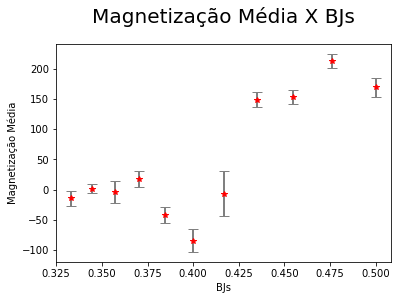

In [23]:
fig = plt.errorbar(BJs, mBarra, mErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Magnetização Média')
plt.title("Magnetização Média X BJs",  y=1.07, size=20)
plt.show()

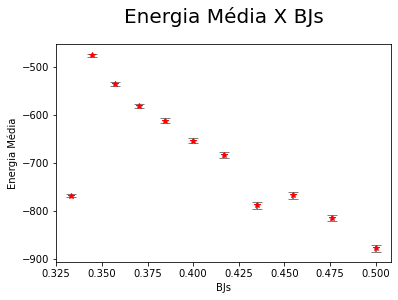

In [24]:
fig = plt.errorbar(BJs, EBarra, EErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Energia Média')
plt.title("Energia Média X BJs",  y=1.07, size=20)
plt.show()

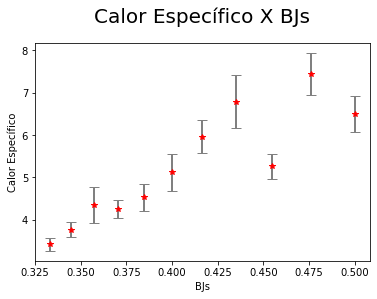

In [25]:
fig = plt.errorbar(BJs, CvBarra, CvErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Calor Específico')
plt.title("Calor Específico X BJs",  y=1.07, size=20)
plt.show()

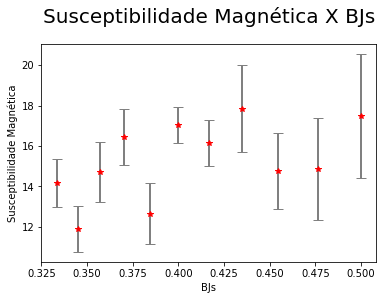

In [26]:
fig = plt.errorbar(BJs, chiBarra, chiErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Susceptibilidade Magnética')
plt.title("Susceptibilidade Magnética X BJs",  y=1.07, size=20)
plt.show()

<font size="5"> Façamos a simulação para uma malha de tamanho linear = $24$:</font>

<font size="5"> Sempre ao mudar o tamanho linear, para usar o numba, visando eficiência, é necessário redefinir as funções do algortimo de metropolis. </font>

In [27]:
tipo = 5
N = 24

@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
    return net_spins, net_energy

@numba.njit("f8[:,:](f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolisArr(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
    return spin_arr

/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


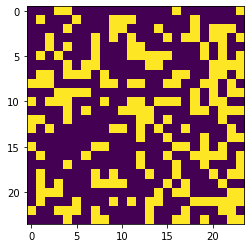

In [28]:
malha = cria_malhas(N,5) #primeira malha aleatória
plt.imshow(malha)

ms = np.zeros((len(BJs),n))
Es = np.zeros((len(BJs),n))
Cvs = np.zeros((len(BJs),n))
chis = np.zeros((len(BJs),n))

In [29]:
for i, bj in enumerate(BJs):  
    if i == 0:
        spins, energies = metropolis(malha, passosMC, bj, get_energy(malha))
        malha_lin = metropolisArr(malha, passosMC, bj, get_energy(malha))
    else:
        spins, energies = metropolis(malha_lin, passosMC, bj, get_energy(malha_lin))
        malha_lin = metropolisArr(malha_lin, passosMC, bj, get_energy(malha_lin))
    for caixas in reversed(range(n)): 
        if caixas > 0:
            ms[i][caixas] = spins[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].mean()
            Es[i][caixas] = energies[- int(1e4) * (caixas + 1) : - int(1e4) * caixas ].mean()
            Cvs[i][caixas] = BJs[i] * BJs[i] * energies[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].std()
            chis[i][caixas] = BJs[i] * spins[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].std()
        elif caixas == 0:
            ms[i][caixas] = spins[- int(1e4) : ].mean()
            Es[i][caixas] = energies[- int(1e4) : ].mean()
            Cvs[i][caixas] = BJs[i] * BJs[i] * energies[- int(1e4) : ].std()
            chis[i][caixas] = BJs[i] * spins[- int(1e4) : ].std()

In [30]:
mBarra = np.zeros((len(BJs)))
EBarra = np.zeros((len(BJs)))
CvBarra = np.zeros((len(BJs)))
chiBarra = np.zeros((len(BJs)))

for BJ in range(len(BJs)):
    mBarra[BJ] = ms[BJ].mean()
    EBarra[BJ] = Es[BJ].mean()
    CvBarra[BJ] = Cvs[BJ].mean()
    chiBarra[BJ] = chis[BJ].mean()

mErr = np.zeros((len(BJs)))
EErr = np.zeros((len(BJs)))
CvErr = np.zeros((len(BJs)))
chiErr = np.zeros((len(BJs)))

for BJ in range(len(BJs)):
    mSoma = 0
    ESoma = 0
    CvSoma = 0
    chiSoma = 0
    for i in range(n):
        mSoma += ( mBarra[BJ] - ms[BJ][i] )**2
        ESoma += ( EBarra[BJ] - Es[BJ][i] )**2
        CvSoma += ( CvBarra[BJ] - Cvs[BJ][i] )**2
        chiSoma += ( chiBarra[BJ] - chis[BJ][i] )**2
    mErr[BJ] = np.sqrt( mSoma / (n * (n - 1)) )
    EErr[BJ] = np.sqrt( ESoma / (n * (n - 1)) )
    CvErr[BJ] = np.sqrt( CvSoma / (n * (n - 1)) )
    chiErr[BJ] = np.sqrt( chiSoma / (n * (n - 1)) )

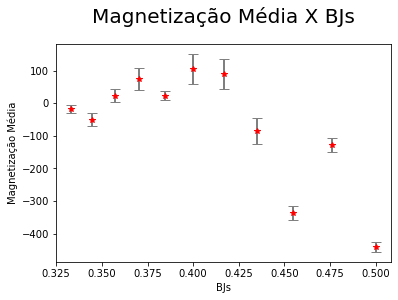

In [31]:
fig = plt.errorbar(BJs, mBarra, mErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Magnetização Média')
plt.title("Magnetização Média X BJs",  y=1.07, size=20)
plt.show()

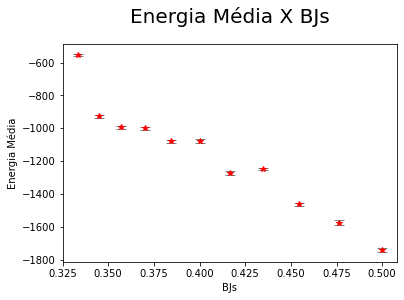

In [32]:
fig = plt.errorbar(BJs, EBarra, EErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Energia Média')
plt.title("Energia Média X BJs",  y=1.07, size=20)
plt.show()

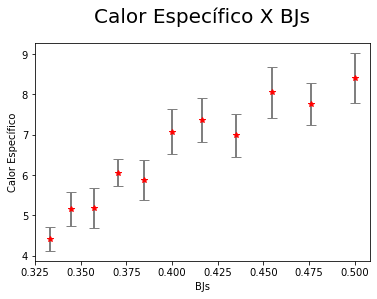

In [33]:
fig = plt.errorbar(BJs, CvBarra, CvErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Calor Específico')
plt.title("Calor Específico X BJs",  y=1.07, size=20)
plt.show()

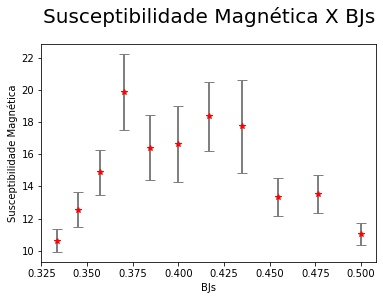

In [34]:
fig = plt.errorbar(BJs, chiBarra, chiErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Susceptibilidade Magnética')
plt.title("Susceptibilidade Magnética X BJs",  y=1.07, size=20)
plt.show()

<font size="5"> Façamos a simulação para uma malha de tamanho linear = $36$: </font>

In [35]:
tipo = 5
N = 36

@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
    return net_spins, net_energy

@numba.njit("f8[:,:](f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolisArr(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
    return spin_arr

/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


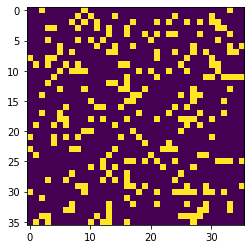

In [36]:
malha = cria_malhas(N,5) #primeira malha aleatória
plt.imshow(malha)
mBarra = np.zeros((len(BJs)))
EBarra = np.zeros((len(BJs)))
CvBarra = np.zeros((len(BJs)))
chiBarra = np.zeros((len(BJs)))

In [37]:
for i, bj in enumerate(BJs):  
    if i == 0:
        spins, energies = metropolis(malha, passosMC, bj, get_energy(malha))
        malha_lin = metropolisArr(malha, passosMC, bj, get_energy(malha))
    else:
        spins, energies = metropolis(malha_lin, passosMC, bj, get_energy(malha_lin))
        malha_lin = metropolisArr(malha_lin, passosMC, bj, get_energy(malha_lin))
    for caixas in reversed(range(n)): 
        if caixas > 0:
            ms[i][caixas] = spins[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].mean()
            Es[i][caixas] = energies[- int(1e4) * (caixas + 1) : - int(1e4) * caixas ].mean()
            Cvs[i][caixas] = BJs[i] * BJs[i] * energies[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].std()
            chis[i][caixas] = BJs[i] * spins[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].std()
        elif caixas == 0:
            ms[i][caixas] = spins[- int(1e4) : ].mean()
            Es[i][caixas] = energies[- int(1e4) : ].mean()
            Cvs[i][caixas] = BJs[i] * BJs[i] * energies[- int(1e4) : ].std()
            chis[i][caixas] = BJs[i] * spins[- int(1e4) : ].std()

In [38]:
#print(f"{ms}\n{Es}\n{Cvs}\n{chis}")

In [39]:
mBarra = np.zeros((len(BJs)))
EBarra = np.zeros((len(BJs)))
CvBarra = np.zeros((len(BJs)))
chiBarra = np.zeros((len(BJs)))

for BJ in range(len(BJs)):
    mBarra[BJ] = ms[BJ].mean()
    EBarra[BJ] = Es[BJ].mean()
    CvBarra[BJ] = Cvs[BJ].mean()
    chiBarra[BJ] = chis[BJ].mean()

mErr = np.zeros((len(BJs)))
EErr = np.zeros((len(BJs)))
CvErr = np.zeros((len(BJs)))
chiErr = np.zeros((len(BJs)))

for BJ in range(len(BJs)):
    mSoma = 0
    ESoma = 0
    CvSoma = 0
    chiSoma = 0
    for i in range(n):
        mSoma += ( mBarra[BJ] - ms[BJ][i] )**2
        ESoma += ( EBarra[BJ] - Es[BJ][i] )**2
        CvSoma += ( CvBarra[BJ] - Cvs[BJ][i] )**2
        chiSoma += ( chiBarra[BJ] - chis[BJ][i] )**2
    mErr[BJ] = np.sqrt( mSoma / (n * (n - 1)) )
    EErr[BJ] = np.sqrt( ESoma / (n * (n - 1)) )
    CvErr[BJ] = np.sqrt( CvSoma / (n * (n - 1)) )
    chiErr[BJ] = np.sqrt( chiSoma / (n * (n - 1)) )

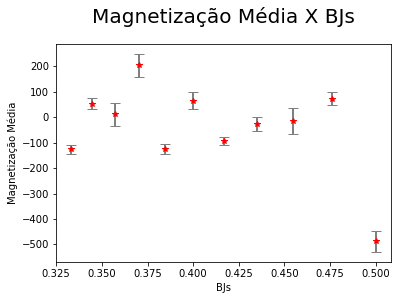

In [40]:
fig = plt.errorbar(BJs, mBarra, mErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Magnetização Média')
plt.title("Magnetização Média X BJs",  y=1.07, size=20)
plt.show()

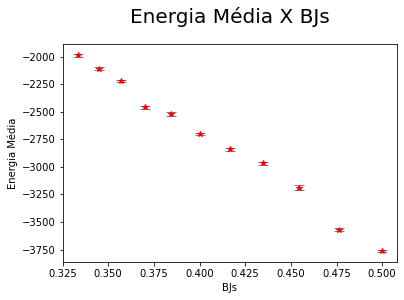

In [41]:
fig = plt.errorbar(BJs, EBarra, EErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Energia Média')
plt.title("Energia Média X BJs",  y=1.07, size=20)
plt.show()

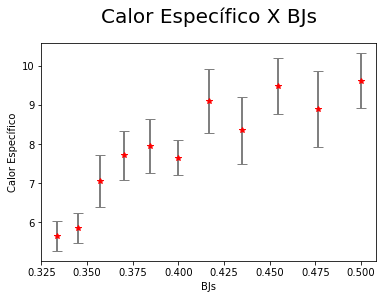

In [42]:
fig = plt.errorbar(BJs, CvBarra, CvErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Calor Específico')
plt.title("Calor Específico X BJs",  y=1.07, size=20)
plt.show()

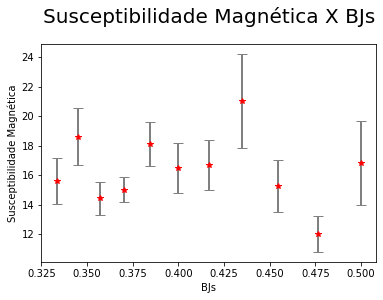

In [43]:
fig = plt.errorbar(BJs, chiBarra, chiErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Susceptibilidade Magnética')
plt.title("Susceptibilidade Magnética X BJs",  y=1.07, size=20)
plt.show()

<font size="5"> Façamos a simulação para uma malha de tamanho linear = $48$: </font>

In [44]:
tipo = 5
N = 48

@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
    return net_spins, net_energy

@numba.njit("f8[:,:](f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolisArr(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
    return spin_arr

/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


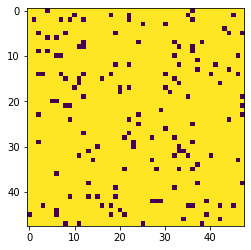

In [45]:
malha = cria_malhas(N,5) #primeira malha aleatória
plt.imshow(malha)
mBarra = np.zeros((len(BJs)))
EBarra = np.zeros((len(BJs)))
CvBarra = np.zeros((len(BJs)))
chiBarra = np.zeros((len(BJs)))

In [46]:
for i, bj in enumerate(BJs):  
    if i == 0:
        spins, energies = metropolis(malha, passosMC, bj, get_energy(malha))
        malha_lin = metropolisArr(malha, passosMC, bj, get_energy(malha))
    else:
        spins, energies = metropolis(malha_lin, passosMC, bj, get_energy(malha_lin))
        malha_lin = metropolisArr(malha_lin, passosMC, bj, get_energy(malha_lin))
    for caixas in reversed(range(n)): 
        if caixas > 0:
            ms[i][caixas] = spins[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].mean()
            Es[i][caixas] = energies[- int(1e4) * (caixas + 1) : - int(1e4) * caixas ].mean()
            Cvs[i][caixas] = BJs[i] * BJs[i] * energies[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].std()
            chis[i][caixas] = BJs[i] * spins[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].std()
        elif caixas == 0:
            ms[i][caixas] = spins[- int(1e4) : ].mean()
            Es[i][caixas] = energies[- int(1e4) : ].mean()
            Cvs[i][caixas] = BJs[i] * BJs[i] * energies[- int(1e4) : ].std()
            chis[i][caixas] = BJs[i] * spins[- int(1e4) : ].std()

In [47]:
mBarra = np.zeros((len(BJs)))
EBarra = np.zeros((len(BJs)))
CvBarra = np.zeros((len(BJs)))
chiBarra = np.zeros((len(BJs)))

for BJ in range(len(BJs)):
    mBarra[BJ] = ms[BJ].mean()
    EBarra[BJ] = Es[BJ].mean()
    CvBarra[BJ] = Cvs[BJ].mean()
    chiBarra[BJ] = chis[BJ].mean()

mErr = np.zeros((len(BJs)))
EErr = np.zeros((len(BJs)))
CvErr = np.zeros((len(BJs)))
chiErr = np.zeros((len(BJs)))

for BJ in range(len(BJs)):
    mSoma = 0
    ESoma = 0
    CvSoma = 0
    chiSoma = 0
    for i in range(n):
        mSoma += ( mBarra[BJ] - ms[BJ][i] )**2
        ESoma += ( EBarra[BJ] - Es[BJ][i] )**2
        CvSoma += ( CvBarra[BJ] - Cvs[BJ][i] )**2
        chiSoma += ( chiBarra[BJ] - chis[BJ][i] )**2
    mErr[BJ] = np.sqrt( mSoma / (n * (n - 1)) )
    EErr[BJ] = np.sqrt( ESoma / (n * (n - 1)) )
    CvErr[BJ] = np.sqrt( CvSoma / (n * (n - 1)) )
    chiErr[BJ] = np.sqrt( chiSoma / (n * (n - 1)) )

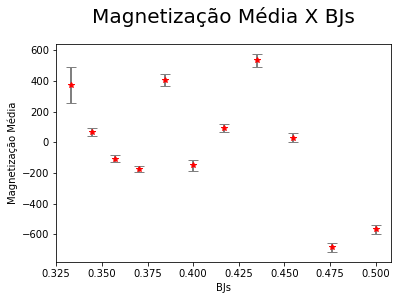

In [48]:
fig = plt.errorbar(BJs, mBarra, mErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Magnetização Média')
plt.title("Magnetização Média X BJs",  y=1.07, size=20)
plt.show()

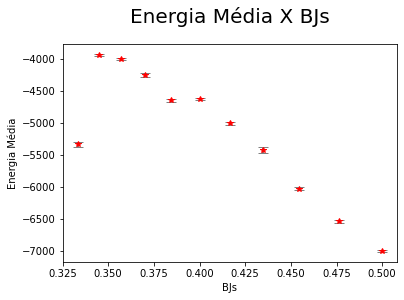

In [49]:
fig = plt.errorbar(BJs, EBarra, EErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Energia Média')
plt.title("Energia Média X BJs",  y=1.07, size=20)
plt.show()

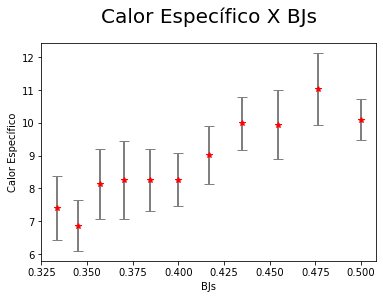

In [50]:
fig = plt.errorbar(BJs, CvBarra, CvErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Calor Específico')
plt.title("Calor Específico X BJs",  y=1.07, size=20)
plt.show()

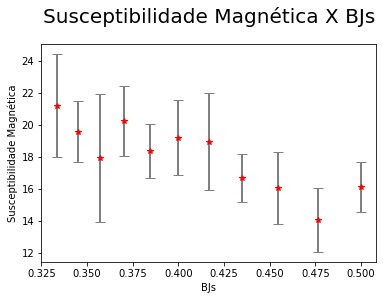

In [51]:
fig = plt.errorbar(BJs, chiBarra, chiErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Susceptibilidade Magnética')
plt.title("Susceptibilidade Magnética X BJs",  y=1.07, size=20)
plt.show()

<font size="5"> Conclusões: </font>

Observamos que, a medida que o sistema aumenta os erros estatísticos tendem a aumentar ligeiramente. Então, para uma abstração de uma malha infinita, é de se esperar, a grosso modo, que haja um erro infinito, sendo assim, impossível prever de fato as grandezas do sistema. 

Além disso, vemos que, qualitivamente, os erros estatísticos tender a diminiur com o aumento de $\beta \cdot J$. Ou seja, em uma temperatura maior, os erros são maiores. Uma possível razão para isso é o fator de mudança introduzido pelo excesso de energia.

<font size="5"> Colocamos o tamanho linear em 48 e digressamos sobre o fenômeno da mudança de fases para duas malhas: Uma que começa com 75% dos spins positivos e outra que começa com 75% dos spins negativos:</font>

In [52]:
tipo = 5
N = 48

@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
    return net_spins, net_energy

@numba.njit("f8[:,:](f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolisArr(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
    return spin_arr

/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [53]:
malhaP = cria_malhas(N,4)
malhaN = cria_malhas(N,3)

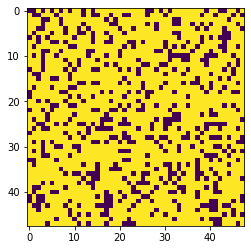

In [54]:
plt.imshow(malhaP)

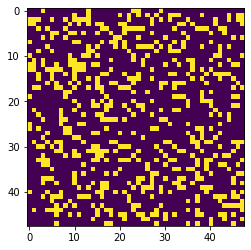

In [55]:
plt.imshow(malhaN)

<font size="5"> Encontraremos valores médios para a energia e magnetização, suposto atigindo a termalização, para dada uma temperatura BJ, e realizamos uma média nos últimos 100,000 passos de Monte Carlo.  </font>

In [56]:
def getSEBarra(malha, BJs, passosMC):
    mBarra = np.zeros(len(BJs))
    EBarra = np.zeros(len(BJs))
    EStds = np.zeros(len(BJs)) #standard deviation
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(malha, passosMC, bj, get_energy(malha))
        mBarra[i] = spins[- int(1e5):].mean()
        EBarra[i] = energies[- int(1e5):].mean()
        EStds[i] = energies[- int(1e5):].std()
    return mBarra, EBarra, EStds

In [57]:
passosMC = 1e6
BJs = np.arange(0.1, 2, 0.05)
mBarraP, EBarraP, EStdsP = getSEBarra(malhaP, BJs, passosMC)
mBarraN, EBarraN, EStdsN = getSEBarra(malhaN, BJs, passosMC)

<font size="5"> Podemos olhar $\bar{m}$ como função da temperatura $T = 1/\beta = J/(\beta J)$ </font>

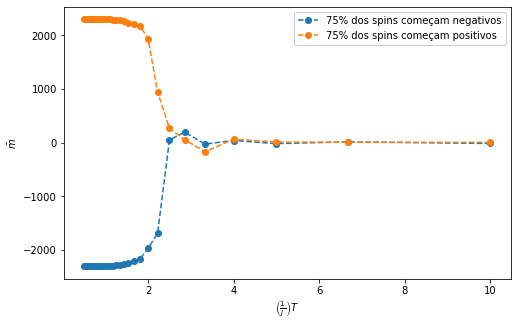

In [58]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, mBarraN, 'o--', label='75% dos spins começam negativos')
plt.plot(1/BJs, mBarraP, 'o--', label='75% dos spins começam positivos')
plt.xlabel(r'$\left(\frac{1}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

O gráfico acima exibe a variação do spin médio $\overline{m}$ com aumento da temperatura $\frac{T}{J}$. Dele, podemos concluir que, se a temperatura está baixa o suficiente, qualitivamente, abaixo de 2, a malha fica magnetizada, i.e., os spins que estão em minoria tendem a se alinhar com os spins que estão em maioria. Por outro lado, se a temperatura está alta o suficiente, qualitativamente, acima de 3, a malha perde sua magnetização, i.e., os spins se alinham de tal forma que $\overline{m} = 0$. Disso, é de se esperar que a malha passe por uma mudança de fase quando a temperatura está entre 2 e 3.